In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, io, time
import urllib

import pandas
import numpy
import librosa
import scipy.io.wavfile
import scipy.ndimage
import skimage.io

import tempfile
import gcsfs

import librosa.display
import IPython
import matplotlib.pyplot as plt

# Custom modules
import dcase2018bird
import features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset = dcase2018bird.load_dataset()
print(dataset.shape)
dataset.head(3)

(48310, 4)


,itemid,datasetid,hasbird,folder
0,BUK4_20161103_204504_125,PolandNFC,NaN,polandnfc
1,BUK4_20161016_012704_132,PolandNFC,NaN,polandnfc
2,6wichura_deszcz_BUK4_20161005_022304_129,PolandNFC,NaN,polandnfc


In [3]:
def read_audio(url):
    f = urllib.request.urlopen(url)
    data = io.BytesIO(f.read())
    samplerate, samples  = scipy.io.wavfile.read(data)
    assert samplerate == 44100, samplerate
    data = samples.astype('float')/32768
    return samplerate, data

def melspec(data, sr, subtract='median', n_mels=64, fmin=500, fmax=15000, htk=True,):
    from librosa.feature import melspectrogram
    
    mel = melspectrogram(y=data, sr=sr,
                         n_mels=n_mels, fmin=fmin, fmax=fmax, htk=True)
    mel = librosa.core.amplitude_to_db(mel, ref=1.0)
    
    if not subtract:
        pass #disabled
    elif subtract == 'mean':
        mel = mel - (numpy.mean(mel, axis=1, keepdims=True) + 1e-8)
    elif subtract == 'median':
        mel = mel - (numpy.median(mel, axis=1, keepdims=True) + 1e-8)
    else:
        raise ValueError('Unsupported subtract={}'.format(subtract))

    return mel

example_url = list(dcase2018bird.wav_urls(dataset[dataset.hasbird == True]))[100]
print('Example URL:', example_url)
example_sr, example_data = read_audio(example_url)
print('File samplerate, length:', example_sr, example_data.shape)
IPython.display.Audio(example_url)

Example URL: https://storage.googleapis.com/dcase2018-bad/birdvox/wav/025ea196-b222-4a1a-a102-473fe78af7c8.wav
File samplerate, length: 44100 (441000,)


Mel spectrogram shape: (64, 862)


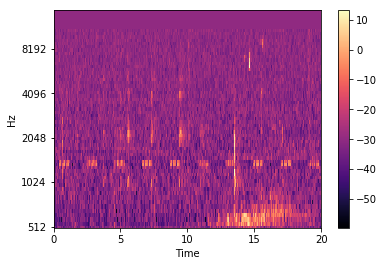

In [4]:
example_mel = melspec(example_data, example_sr)
print('Mel spectrogram shape:', example_mel.shape)
librosa.display.specshow(example_mel+example_mel.min(), y_axis='mel', x_axis='time', fmin=500, fmax=15000)
plt.colorbar()

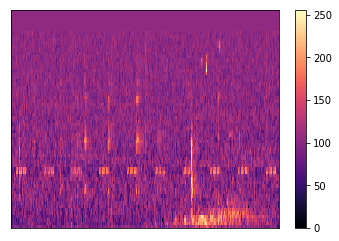

In [5]:
def quantize_8bit(s):
    out_min = 0
    out_max = 255
    in_min, in_max = s.min(), s.max()
    
    std = (s - in_min) / (in_max - in_min)
    scaled = std * (out_max - out_min) + out_min
    return scaled.astype(numpy.uint8)

librosa.display.specshow(quantize_8bit(example_mel))
plt.colorbar()

ex (64, 862)


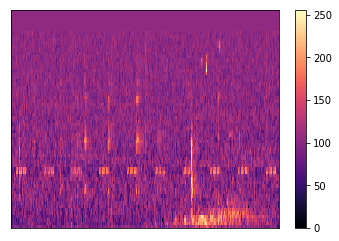

In [8]:
example_path = 'example.melspec.png'
skimage.io.imsave(example_path, quantize_8bit(example_mel))

example_read = skimage.io.imread(example_path)
print('ex', example_read.shape)
librosa.display.specshow(example_read)
plt.colorbar()

In [ ]:
gs = gcsfs.GCSFileSystem('mlcluster-217913', token='browser')
gs.buckets

In [10]:
def upload_image(filesystem, remote_path, spectrogram):
    ext = os.path.splitext(remote_path)[1]
    # NOTE: probably cannot open file twice on Windows filesytems
    with tempfile.NamedTemporaryFile(delete=True, prefix='bird', suffix=ext) as f:
        skimage.io.imsave(f.name, spectrogram)
        filesystem.put(f.name, remote_path)
        
upload_image(gs, 'dcase2018-bad/features/test.png', quantize_8bit(example_mel))
r = urllib.request.urlopen('https://storage.googleapis.com/dcase2018-bad/features/test.png')
assert r.status == 200, r.status

In [12]:
gs_prefix = 'dcase2018-bad/features/melspec-htk-b64-fmin500-fmax15000'
# I've seen that not all the files are a full 10 seconds
frames_length = 850
def upload_melspec(folder, itemid, ext='.jpg'):
    url = dcase2018bird.wav_url(folder, itemid) 
    path = os.path.join(gs_prefix, folder, itemid+ext)
    
    sr, data = read_audio(url)
    mel = melspec(data, sr, n_mels=64)
    mel = quantize_8bit(mel)
    cropped = mel[:, 0:frames_length]
    #print('uploading', path)
    
    upload_image(gs, path, cropped)

upload_melspec(*list(zip(dataset.folder, dataset.itemid))[0])


In [16]:
import sys
def melspec_all(dataset):
    items = list(zip(dataset.folder, dataset.itemid))[50+89:]

    for i, (folder, itemid) in enumerate(items):
        upload_melspec(folder, itemid)
        sys.stdout.write('\r {}/{}'.format(i, len(items)))

melspec_all(dataset);

URLError: <urlopen error [Errno -2] Name or service not known>

In [ ]:
assert False

import dask.distributed
scheduler = os.environ.get('DASK_SCHEDULER', None) # set to 'mycluster:port' to use remote cluster
c = dask.distributed.Client(scheduler)
c

In [ ]:
# Upload our custom Python modules to workers
c.upload_file('features.py')
c.upload_file('dcase2018bird.py')

In [ ]:
melspec_shape = (64, frames_length)
def extract_melspec(url):
    sr, data = read_audio(url)
    mel = melspec(data, sr, n_mels=64)
    mel = quantize_8bit(mel)
    
    cropped = mel[:, 0:frames_length]
    
    path = os.path.join(gs_prefix, )
    upload_image(gs, )
    
    return cropped
    
train_melspecs = features.extract(dcase2018bird.wav_urls(dataset[dataset.hasbird == True]),
                                  extract_melspec, melspec_shape, dtype=numpy.float)
ex = train_melspecs[0:10, :, :].compute()

In [ ]:
ex.dtype, ex.shape